In [127]:
from jqdatasdk import *
import numpy as np
import pandas as pd
auth('id','password') #ID是申请时所填写的手机号；Password为聚宽官网登录密码，新申请用户默认为手机号后6位
get_query_count()#当前剩余可用数据条数

{'spare': 1000000, 'total': 1000000}

In [128]:
#get_industry_stocks('I64')# 获取计算机/互联网行业的成分股
#get_index_stocks('399951.XSHE', date=None)#获取沪深300银行指数成分股

In [129]:
#该函数能够获得指定时间，指定股票成分股的截面数据
def getdata(stock,datetime,gap):
    #调取截面数据、计算月收益率数据
    sample = get_index_stocks(stock, date=datetime)#股票除选择沪深300银行指数成分股
    q = query(valuation.code, 
              valuation.market_cap,#市值
              valuation.circulating_market_cap,
              balance.total_assets - balance.total_liability,#净资产
              balance.total_assets / balance.total_liability, 
              indicator.net_profit_to_total_revenue, #净利润/营业总收入
              indicator.inc_revenue_year_on_year,  #营业收入增长率（同比）
              balance.development_expenditure, #RD
              valuation.pe_ratio, #市盈率（TTM）
              valuation.pb_ratio, #市净率（TTM）
              indicator.inc_net_profit_year_on_year,#净利润增长率（同比）
              balance.dividend_payable,
              indicator.roe,
              indicator.roa,
              income.operating_profit / income.total_profit, #OPTP
              indicator.gross_profit_margin, #销售毛利率GPM
              balance.fixed_assets / balance.total_assets, #FACR
              valuation.pcf_ratio, #CFP
              valuation.ps_ratio #PS
            ).filter(
                valuation.code.in_(sample)
            )
    df = get_fundamentals(q, date =datetime)
    #df.index = df.code.values
    del df['code']
    df = df.fillna(0)
    
    #解决数据日期问题 选取未来一个月的日期
    year = int(datetime[:4])
    month = int(datetime[5:7])
    day=int(datetime[8:10])
    if month == 12:       
        nexttime = str(year+1)+'-'+str(gap)+'-'+str(day)
    else:  
        nexttime = str(year)+'-'+str(month+gap)+'-'+str(day)
        
    #构建特征和标签
    sample2 = get_index_stocks(stock, date=nexttime)#股票除选择沪深300银行指数成分股
    q2 = query(valuation.code, 
              valuation.market_cap,#市值
            ).filter(
                valuation.code.in_(sample2)
            )
    df2=get_fundamentals(q2, date = nexttime)
    del df2['code']
    monthreturn=pd.DataFrame(df2['market_cap'].values/df['market_cap'].values, columns=['monthreturn'])
    df=pd.concat([df,monthreturn],axis=1)
    #df即为我们的训练集 用来训练回归模型 筛选变量和权重
    return df

In [130]:
#构建一个日期表，从这些日期中选取截面数据
def return_datelist(start_date,end_date):
    datelist=[]
    #start_date:str, 初始日期
    #end_date:str,终止日期
    start_year = int(start_date[:4])
    end_year = int(end_date[:4])
    start_month = int(start_date[5:7])
    end_month = int(end_date[5:7])
    start_day=int(start_date[8:10])
    end_day=int(end_date[8:10])
    for i in range(end_month):
        if(end_month-i<10):
            date=str(end_year)+'-'+'0'+str(end_month-i)+'-'+str(end_day)
            datelist=datelist+[date]
        else:
            date=str(end_year)+'-'+str(end_month-i)+'-'+str(end_day)
            datelist=datelist+[date]
    for i in range(13-start_month):
        if(start_month+i<10):
            date=str(start_year)+'-'+'0'+str(start_month+i)+'-'+str(start_day)
            datelist=datelist+[date]
        else:
            date=str(start_year)+'-'+str(start_month+i)+'-'+str(start_day)
            datelist=datelist+[date]          
        current_year=start_year+1
    while(current_year!=end_year):
        for i in range(11):
            if(i+1<10):
                date=str(current_year)+'-'+'0'+str(i+1)+'-'+str(start_day)
                datelist=datelist+[date]
            else:
                date=str(current_year)+'-'+str(i+1)+'-'+str(start_day)
                datelist=datelist+[date]
        current_year=current_year+1
    return datelist    

In [157]:
#获得训练数据集
datelist=return_datelist(start_date='2013-10-15',end_date='2015-10-15')
df=getdata(stock='399951.XSHE',datetime='2013-10-15',gap=1)
for i in datelist:
    dfnew=getdata(stock='399951.XSHE',datetime=i,gap=1)
    df=pd.concat([df,dfnew],axis=0)
df.shape

(400, 19)

In [158]:
#借助训练集进行回归模型的训练 归一化数据
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
df1=min_max_scaler.fit_transform(df)
df2 = pd.DataFrame(df1, columns=df.columns)
df2.shape

(400, 19)

In [159]:
y=df2['monthreturn']
x=df2.drop(columns = ['monthreturn'])
x.shape,y.shape

((400, 18), (400,))

[-1.84304025e-01 -3.06198850e-02  1.60895871e-01  1.70025869e-01
 -4.78423493e-02  1.76786229e-01 -8.74300632e-16  1.58766816e-01
 -3.79950914e-01 -2.63670587e-01  3.39311135e-02  3.43374766e-01
 -2.79462321e-01  9.18125757e-02  0.00000000e+00  1.13152446e-02
 -4.61600751e-02 -4.52255485e-02]


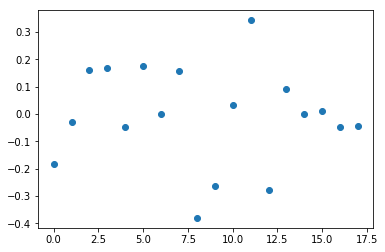

In [160]:
#利用线性模型得到权重
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(x, y)
print(lr.coef_)
plt.plot(lr.coef_,'o', label = 'linear regression')

[-0.         -0.          0.          0.          0.02263684  0.12729578
  0.         -0.         -0.00548703  0.          0.          0.
  0.          0.10214221  0.          0.01761991  0.42324258 -0.        ]


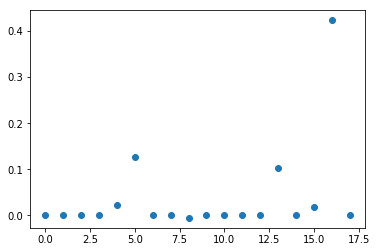

In [161]:
#利用线性模型得到权重
from sklearn.linear_model import Lasso
lasso = Lasso(fit_intercept=False)
lasso.set_params(alpha=0.004)
lasso.fit(x, y)
print(lasso.coef_)
plt.plot(lasso.coef_,'o', label = 'linear regression')

[-0.01834382 -0.01282341 -0.          0.00508764 -0.00061548  0.08580345
  0.         -0.00359498 -0.12210169 -0.          0.         -0.00643674
 -0.          0.          0.          0.00116625 -0.         -0.06356195]


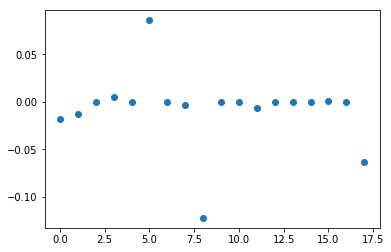

In [162]:
#利用线性模型得到权重
from sklearn.linear_model import ElasticNet
enet=ElasticNet(alpha=.01,l1_ratio=0.06)
enet.fit(x, y)
print(enet.coef_)
plt.plot(enet.coef_,'o', label = 'linear regression')

In [119]:
#开始模拟投资 读取当天的相关截面数据 预测收益率 并对股票按收益率排序
sample3 = get_index_stocks('399951.XSHE', date=None)#股票除选择沪深300银行指数成分股
q3 = query(valuation.code, 
          valuation.market_cap,#市值
          valuation.circulating_market_cap,
          balance.total_assets - balance.total_liability,#净资产
          balance.total_assets / balance.total_liability, 
          indicator.net_profit_to_total_revenue, #净利润/营业总收入
          indicator.inc_revenue_year_on_year,  #营业收入增长率（同比）
          balance.development_expenditure, #RD
          valuation.pe_ratio, #市盈率（TTM）
          valuation.pb_ratio, #市净率（TTM）
          indicator.inc_net_profit_year_on_year,#净利润增长率（同比）
          balance.dividend_payable,
          indicator.roe,
          indicator.roa,
          income.operating_profit / income.total_profit, #OPTP
          indicator.gross_profit_margin, #销售毛利率GPM
          balance.fixed_assets / balance.total_assets, #FACR
          valuation.pcf_ratio, #CFP
          valuation.ps_ratio #PS
        ).filter(
            valuation.code.in_(sample3)
        )
df = get_fundamentals(q3,date=None)
df.index = df.code.values
del df['code']
df = df.fillna(0)

In [120]:
#实现预测+排序
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
df1=min_max_scaler.fit_transform(df)
df2 = pd.DataFrame(df1, columns=df.columns,index=df.index)
x=df2
factor = pd.DataFrame(lr.predict(x), index = df.index, columns = ['monthreturn'])
factor = factor.sort_index(by = 'monthreturn')#做了个排序
stockset = list(factor.index[:10])#选排名前十的股票

E:\anoconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  if sys.path[0] == '':


In [121]:
stockset

['600036.XSHG',
 '002142.XSHE',
 '601838.XSHG',
 '601009.XSHG',
 '601166.XSHG',
 '601997.XSHG',
 '601577.XSHG',
 '601229.XSHG',
 '600928.XSHG',
 '600926.XSHG']